Imports

In [29]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import os

In [55]:
def get_funcs(b,c,max_speed):
    #Speed of leading car
    def v_f(c,t,omega,amplitude_local):
        return c+amplitude_local*np.cos(omega*t)

    #Defining the accelaration function by the PD controller
    def acc(d,v_self,v_front,T_local):
        return b*(v_front-v_self)+c*(d-v_front*T_local)

    #Defining adjusted accelaration function
    # c1 is the lower limit of the 'rate-zero'. 
    # c2 is the upper limit of the 'rate-zero'. 
    # c3 is the lower limit, where the acceleration becomes constant.
    # c4 is the upper limit, where the acceleration becomes constant.
    def acc_adj(a, v_self, c1, c2, c3, c4, k, l):
        g = (c4/2)*((max_speed-v_self)/max_speed)*(np.abs(np.tanh(l*a))+np.tanh(l*a))+(c3/2)*((max_speed+v_self)/max_speed)*(np.abs(np.tanh(l*a))-np.tanh(l*a))
        f = 1+ 1/2*(np.tanh(k * (g - c2)) - np.tanh(k * (g - c1)))
        z = f*g 
        return z
    return v_f,acc,acc_adj


def simulate_system(time_steps,time_period,b,c,omega,amplitude,max_speed, number_of_cars, position, velocity,constant_leading_speed, adjusted_acceleration, c1,c2,c3,c4,k,l):
    v_f,acc,acc_adj = get_funcs(b,c,max_speed)
    # time_steps = 100000
    # time_period = 120
    step_size = time_period/time_steps

    relative_position = []
    for i in range(number_of_cars-1):
        relative_position.append([])
        relative_position[i].append(position[i][0]-position[i+1][0])

    # Using eulers method
    for i in range(time_steps):
        for j in range(number_of_cars):
            position[j].append(position[j][i] + velocity[j][i]*step_size)
            if j != 0:
                relative_position[j-1].append(position[j-1][i] - position[j][i])
            if j == 0:
                velocity[j].append(v_f(constant_leading_speed,(i*step_size),omega,amplitude))
            else:
                if adjusted_acceleration:
                    a_temp = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
                    a = acc_adj(a_temp, velocity[j][i], c1,c2,c3,c4,k,l)
                else:
                    a = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
                velocity[j].append(velocity[j][i] + a*step_size)

    return step_size,time_steps,relative_position,acc_adj



def plot_system(step_size, time_steps, velocity, relative_position, number_of_cars,b,c,omega,T, x_range):
    # Create time array
    time = np.array([i * step_size for i in range(time_steps+1)])
    velocity = np.array(velocity)
    relative_position = np.array(relative_position)

    time_idxs1 = x_range[0]<time
    time_idxs2 = x_range[1]>time[time_idxs1]

    time = time[time_idxs1][time_idxs2]
    velocity =  velocity[:,time_idxs1][:,time_idxs2]
    relative_position = relative_position[:,time_idxs1][:,time_idxs2]

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot velocities
    for i in range(number_of_cars):
        if i == 0:
            axes[0].plot(time, velocity[i], label="Lead Car", linewidth=2)
        else:
            axes[0].plot(time, velocity[i], label=f"Car {number_of_cars-i}", linewidth=1.5)

    axes[0].set_title(f"Velocity of Cars Over Time (b={b}, c={c}, w={omega}, T={T})", fontsize=14)
    axes[0].set_ylabel("Velocity (m/s)", fontsize=12)
    axes[0].legend(fontsize=10, loc="upper right")
    axes[0].grid(True, linestyle="--", alpha=0.7)
    axes[0].set_xlim(x_range[0], x_range[1])
    axes[0].set_ylim(
        min(min(row) for row in velocity) - 0.1 * max(max(row) for row in velocity),
        1.1 * max(max(row) for row in velocity),
    )
    axes[0].tick_params(axis='x', labelbottom=True)
    # Plot relative distances
    for i in range(number_of_cars - 1):
        if i == 0:
            axes[1].plot(time, relative_position[i], label=f"Distance: Lead to Car {number_of_cars-1}", linewidth=2)
        else:
            axes[1].plot(
                time,
                relative_position[i],
                label=f"Distance: Car {number_of_cars-i} to Car {number_of_cars-i-1}",
                linewidth=1.5,
            )

    axes[1].set_title(f"Relative Distances Between Cars Over Time (b={b}, c={c}, w={omega}, T={T})", fontsize=14)
    axes[1].set_xlabel("Time (s)", fontsize=12)
    axes[1].set_ylabel("Relative Distance (m)", fontsize=12)
    axes[1].legend(fontsize=10, loc="upper right")
    axes[1].grid(True, linestyle="--", alpha=0.7)
    axes[1].set_xlim(x_range[0], x_range[1])
    axes[1].set_ylim(
        min(min(row) for row in relative_position) - 0.1 * max(max(row) for row in relative_position),
        1.1 * max(max(row) for row in relative_position),
    )

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


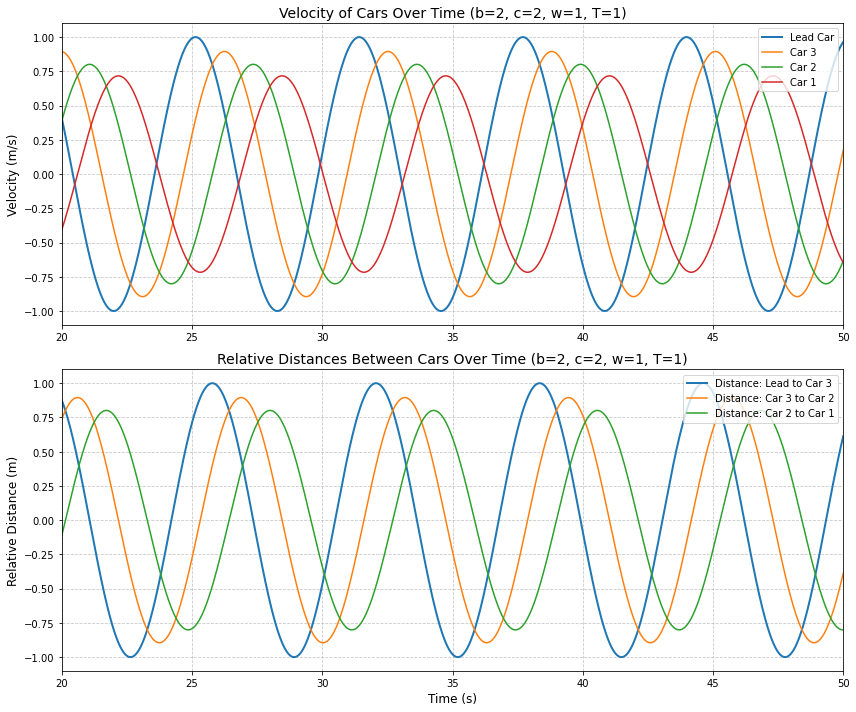

In [56]:
#Defining variables
# Define number of cars including the leader.
#number_of_cars = 2
constant_leading_speed,omega, amplitude = 0, 1, 1
number_of_cars = 4
b,c=2,2
T=1
# Defining constants for adjusted acceleration
c1,c2,c3,c4 = -2,10,-0.5,1
k,l = 10, 0.1
adjusted_acceleration = False 
max_speed = 50
# Defining starting positions
position = [[70*i] for i in range(number_of_cars-1,-1,-1)]
velocity = [[0] for i in range(number_of_cars)]

x_range = [20,50]
time_steps = int(1e5)
time_period = 50
step_size,time_steps,relative_position,acc_adj = simulate_system(time_steps,time_period,b,c,omega,amplitude,max_speed, number_of_cars, position, velocity,constant_leading_speed, adjusted_acceleration, c1,c2,c3,c4,k,l)

plot_system(step_size, time_steps, velocity, relative_position, number_of_cars,b,c,omega,T, x_range)
#adjusted_acceleration = True
#min_speed, max_speed = -10, 50
## Defining starting positions
# position = [[100*i] for i in range(number_of_cars-1,-1,-1)]
# velocity = [[28] for i in range(number_of_cars)]
# relative_position = []
# for i in range(number_of_cars-1):
#     relative_position.append([])
#     relative_position[i].append(position[i][0]-position[i+1][0])

Plotting a_adjusted against a:

In [3]:
#Speed of leading car
def v_f(c,t,omega,amplitude_local):
    return c+amplitude_local*np.cos(omega*t)

#Defining the accelaration function by the PD controller
def acc(d,v_self,v_front,T_local):
    return b*(v_front-v_self)+c*(d-v_front*T_local)

#Defining adjusted accelaration function
# c1 is the lower limit, where the acceleration becomes constant.
# c2 is the upper limit, where the acceleration becomes constant.
# c3 is the lower limit of the 'rate-zero'. 
# c4 is the upper limit of the 'rate-zero'. 
def acc_adj(a, v_self, c1, c2, c3, c4, k, l):
    g = (c2/2)*((max_speed-v_self)/max_speed)*(np.abs(np.tanh(l*a))+np.tanh(l*a))+(c1/2)*((max_speed+v_self)/max_speed)*(np.abs(np.tanh(l*a))-np.tanh(l*a))
    f = 1+ 1/2*(np.tanh(k * (g - c4)) - np.tanh(k * (g - c3)))
    z = f*g 
    return z


Simulation code using eulers method.

In [4]:
time_steps = 100000
time_period = 120
step_size = time_period/time_steps

# Using eulers method
for i in range(time_steps):
    for j in range(number_of_cars):
        position[j].append(position[j][i] + velocity[j][i]*step_size)
        if j != 0:
            relative_position[j-1].append(position[j-1][i] - position[j][i])
        if j == 0:
            velocity[j].append(v_f(constant_leading_speed,(i*step_size),omega,amplitude))
        else:
            if adjusted_acceleration:
                a_temp = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
                a = acc_adj(a_temp, velocity[j][i], c1,c2,c3,c4,k,l)
            else:
                a = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
            velocity[j].append(velocity[j][i] + a*step_size)

Plotting

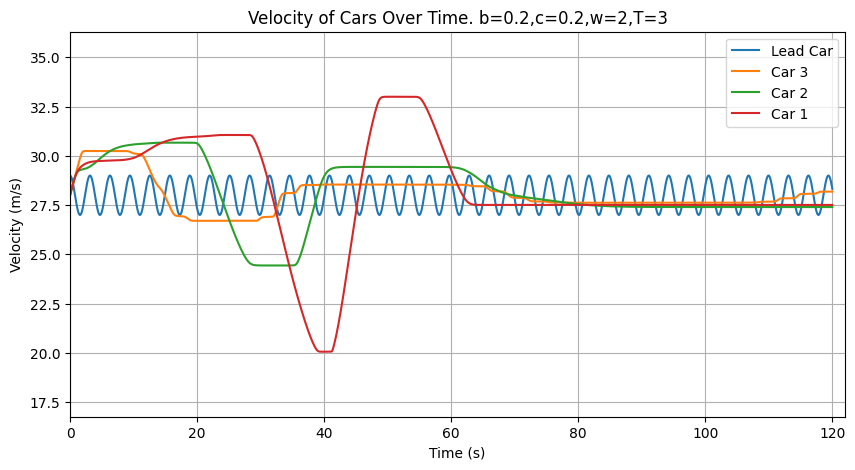

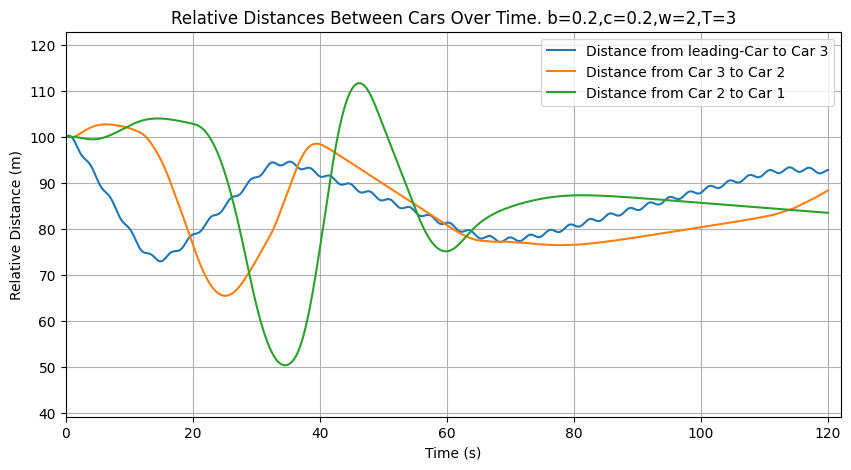

In [5]:
# Create time array
time = [i * step_size for i in range(time_steps+1)]

# Plot velocities
plt.figure(figsize=(10, 5))
for i in range(number_of_cars):
    if i == 0:
        plt.plot(time, velocity[i], label="Lead Car")
    else:
        plt.plot(time, velocity[i], label="Car "+str(number_of_cars-i))
plt.title(f"Velocity of Cars Over Time. b={b},c={c},w={omega},T={T}")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.xlim(0, time_period+2) 
plt.ylim(min(min(row) for row in velocity)-0.1*max(max(row) for row in velocity), 1.1*max(max(row) for row in velocity))  

plt.show()
plt.show()

# Plot relative distances
plt.figure(figsize=(10, 5))
for i in range(number_of_cars-1):
    if i == 0:
        plt.plot(time, relative_position[i], label="Distance from leading-Car to Car "+str(number_of_cars-1))
    else:
        plt.plot(time, relative_position[i], label="Distance from Car "+str(number_of_cars-i)+" to Car "+str(number_of_cars-i-1)) 
plt.title(f"Relative Distances Between Cars Over Time. b={b},c={c},w={omega},T={T}")
plt.xlabel("Time (s)")
plt.ylabel("Relative Distance (m)")
plt.legend()
plt.grid(True)
plt.xlim(0, time_period+2) 
plt.ylim(min(min(row) for row in relative_position)-0.1*max(max(row) for row in relative_position), 1.1*max(max(row) for row in relative_position))  

plt.show()


## Plots for exercise 6

In [6]:
#functions
def f(a):
    term1 = 0.5 * c2 * (np.abs(np.tanh(l * a)) + np.tanh(l * a))
    term2 = 0.5 * c1 * (np.abs(np.tanh(l * a)) - np.tanh(l * a))
    return term1 + term2

def g(a,v): 
    term1 = (c2/2)*((max_speed-v)/max_speed)*(np.abs(np.tanh(l*a))+np.tanh(l*a))
    term2 = (c1/2)*((min_speed-v)/min_speed)*(np.abs(np.tanh(l*a))-np.tanh(l*a))
    return term1 + term2

def h(x):
    return 1 + 0.5 * np.tanh(k * (x - c4)) - 0.5 * np.tanh(k * (x - c3))

In [7]:
def make_and_save_fig(x,y,plot_n,v,file_name, save, show):
    plt.figure(figsize=(10, 6))

    if plot_n == 1:
        plt.plot(x, y, label=r'$f(a)$')
        # Add horizontal lines for c1 and c2
        plt.axhline(c1, color='red', linewidth=1.5, linestyle='--', label=r'$c_1$')
        plt.axhline(c2, color='blue', linewidth=1.5, linestyle='--', label=r'$c_2$')
        plt.title(r'Plot of $f(a_{PD})$ for $l=0.1$')
        plt.xlabel(r'$a_{PD}$')  
        plt.ylabel(r'$f(a_{PD})$')
    elif plot_n == 2:
        for vel in v:
            g_values = g(x, vel)
            plt.plot(x, g_values, label=f'$g(a_{{PD}},v)$ for v={vel}')
        plt.title(r'Plot of $a_{PD}$ vs $g(a_{PD},v)$ for different velocities')
        plt.xlabel(r'$a_{PD}$')
        plt.ylabel(r'$g(a_{PD},v)$')
    elif plot_n == 3:
        plt.plot(x, y, label=r'$h(a)$')
        # Add horizontal lines for c3 and c4
        plt.axvline(c3, color='red', linewidth=1.5, linestyle='--', label=r'$c_3$')
        plt.axvline(c4, color='blue', linewidth=1.5, linestyle='--', label=r'$c_4$')

        plt.title(r'Plot of $h(x)$ for $k=10$')
        plt.xlabel(r'$x$')  
        plt.ylabel(r'$h(x)$')
    elif plot_n == 4:
        for vel in v:
            g_values = g(x, vel)
            a_adjusted = h(g_values) * g_values
            plt.plot(x, a_adjusted, label=f'$a_{{adj}}$ for v={vel}')
            plt.title(r'Plot of $a_{PD}$ vs $a_{adj}$')
            plt.xlabel(r'$a_{PD}$')
            plt.ylabel(r'$a_{adj}$')


    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    plt.grid(True)
    plt.legend()
    if show:
        plt.show() # see plots
    if save:
        save_path = '/home/andersgad/Documents/Users/local/DTU/9.Semester/01257_Advanced_modelling/Pictures' # change this to your path
        os.makedirs(save_path, exist_ok=True)
        # Save the figure
        file_name = file_name + '.eps'  # Name of the file
        full_path = os.path.join(save_path, file_name)

        plt.savefig(full_path,format='eps')

Generate plots for $f,h,g$ and $a_{adj}$

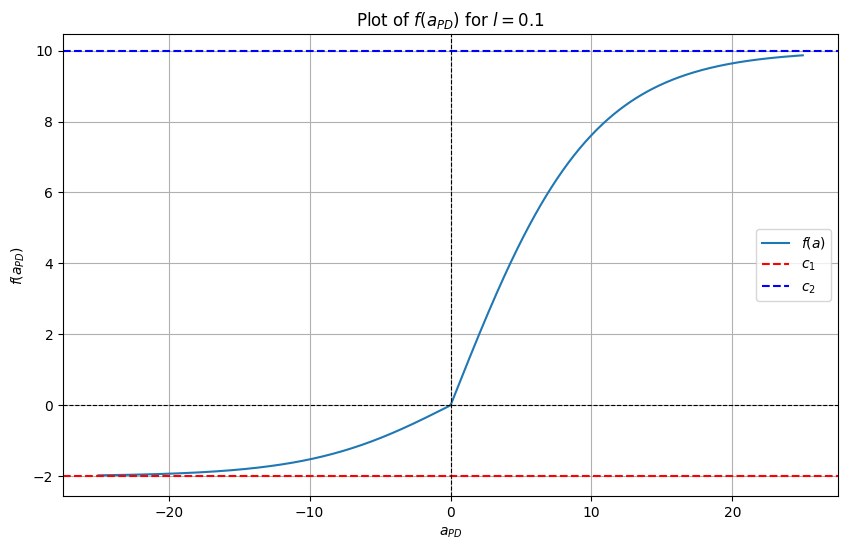

<Figure size 640x480 with 0 Axes>

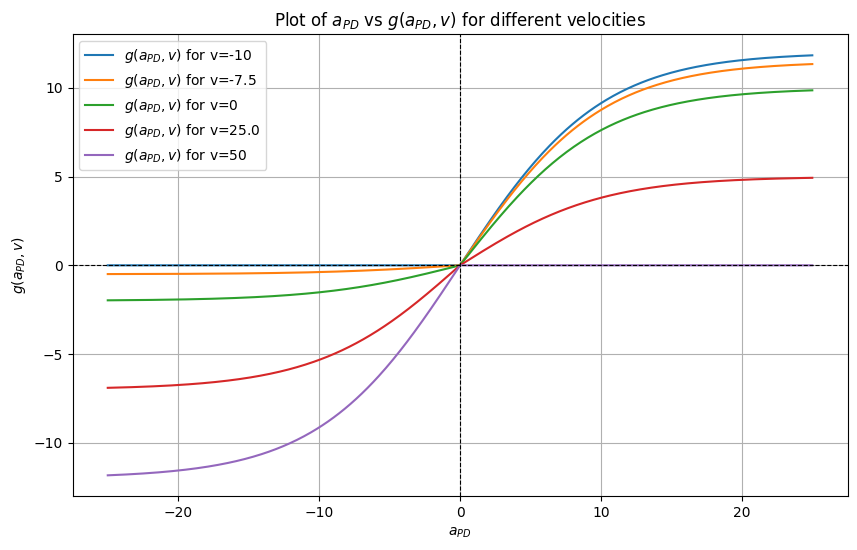

<Figure size 640x480 with 0 Axes>

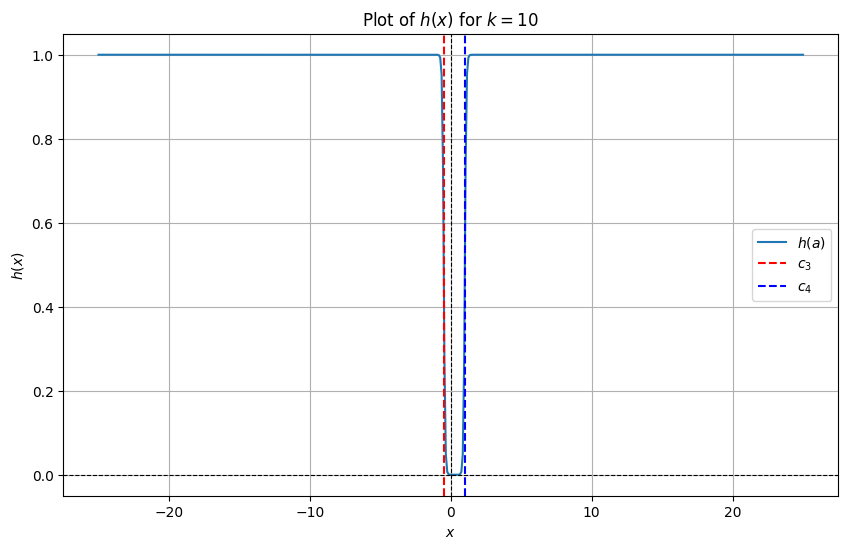

<Figure size 640x480 with 0 Axes>

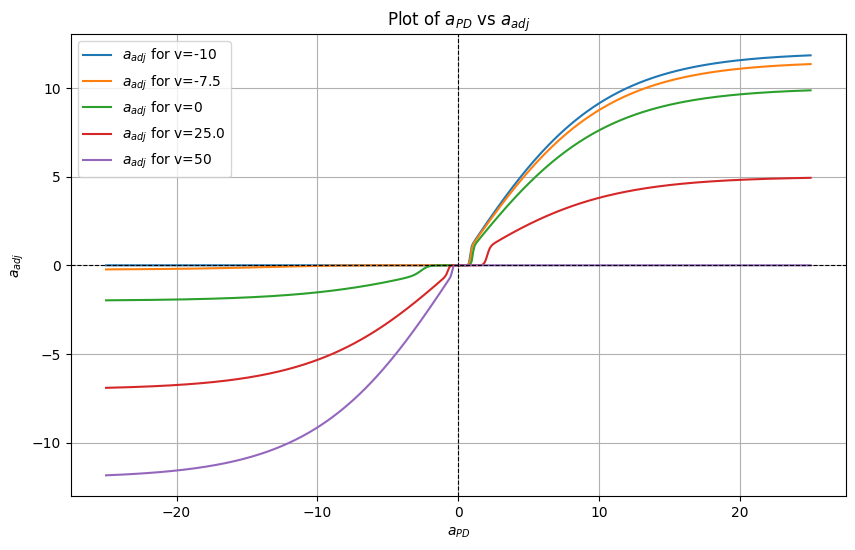

<Figure size 640x480 with 0 Axes>

In [8]:
# Generate the range for a
a = np.linspace(-25, 25, 500)
f_values = f(a)
make_and_save_fig(a,f_values,1,[],'f_function', True, True)
v = [min_speed, 3*min_speed/4, 0, max_speed/2, max_speed]
make_and_save_fig(a, [],2,v,'g_function', True, True)
h_values = h(a)
make_and_save_fig(a,h_values,3,[],'h_function', True, True)
make_and_save_fig(a, [],4,v,'a_adj_function', True, True)